In [1]:
from scipy.special import erf
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1.0,length_scale=2.0)

trainingX = tf.Variable(np.array([[1.0,2,3,4,5]]).T,dtype=tf.float32)
trainingY = tf.Variable(np.array([[1.0,2,3,4,5]]).T-3,dtype=tf.float32)
inducingX = tf.Variable(np.array([1.0,3.5,5.0])[:,None],dtype=tf.float32)
testX = tf.Variable(np.array([[1.1,3.9]]).T,dtype=tf.float32)
testY = tf.Variable(np.array([[1,4]]).T,dtype=tf.float32)

sigmasqr = 2.0**2
invsigmasqr = 1/sigmasqr

def drawcontour(pdist,xmin=-5,xmax=10,ymin=-5,ymax=10,delta=0.1):
    x = np.arange(xmin, xmax, delta,dtype=np.float32)
    y = np.arange(ymin, ymax, delta,dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    plt.contour(x,y,pdist(np.vstack([X.flatten(),Y.flatten()]).T).numpy().reshape(X.shape[0],X.shape[1]))
    
def drawellipse(mu,cov,stds=[2],col='k'):
    """
    mu = mean vector
    cov = covariance matrix
    col = colour
    """
    #based on https://stackoverflow.com/questions/20126061/creating-a-confidence-ellipses-in-a-sccatterplot-using-matplotlib
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')
    plt.plot([mu[0],mu[0]+v[0,0]],[mu[1],mu[1]+v[0,1]])
    for j in stds:
        ell = Ellipse(xy=mu,
                      width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                      angle=np.rad2deg(np.arctan2(v[0,0],v[1,0])),color=col,lw=2)
        ell.set_facecolor('none')
        ax.add_artist(ell)  

/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mike/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
u = np.array([[1,2,3.0],[1,2,3],[3,4,5],[5,4,2]],dtype=np.float32)
Knm = kernel.matrix(trainingX,inducingX)
Kmn = tf.transpose(Knm)
Kmm = kernel.matrix(inducingX,inducingX)
mean = Knm @ tf.linalg.solve(Kmm,tf.transpose(u))
Knn = kernel.matrix(trainingX,trainingX) #to do - need to just use diagonal here. 
cov = Knn - Knm @ tf.linalg.solve(Kmm,Kmn)
#dist = tfd.Normal(mean,np.diag(cov)+1e-6) #tfd.MultivariateNormalFullCovariance(tf.transpose(mean),np.diag(cov)+1e-1)#np.eye(mean.shape[0])*1e-6))
#dist.log_prob(trainingY[:,0])




In [3]:
np.set_printoptions(precision=2,suppress=True)
def logpdist(u):
    """This returns p(y|u=u) which is proportional to p(u|y).
    The surrogate returns q(u)~multivariate Gaussian."""
    Knm = kernel.matrix(trainingX,inducingX)
    Kmn = tf.transpose(Knm)
    Kmm = kernel.matrix(inducingX,inducingX)
    mean = Knm @ tf.linalg.solve(Kmm,tf.transpose(u))
    Knn = kernel.matrix(trainingX,trainingX) #to do - need to just use diagonal here. 
    cov = Knn - Knm @ tf.linalg.solve(Kmm,Kmn) #ditto
    #print(cov)
    dist = tfd.MultivariateNormalDiag(tf.transpose(mean),np.diag(cov)+1e-6) #tfd.MultivariateNormalFullCovariance(tf.transpose(mean),np.diag(cov)+1e-1)#np.eye(mean.shape[0])*1e-6))
    prior = tfd.MultivariateNormalFullCovariance(tf.zeros(inducingX.shape[0]),Kmm)
    return dist.log_prob(trainingY[:,0])#+prior.log_prob(u)

def maybe_surrogate_posterior():
    #So if i understand, in your surrogate_posterior you actually want it to return q(f) so you can evaluate the expected log likelihood, ie it should return:
    #q(f) = N(f | mean, cov)
    #mean=K(X, Z)K(Z, Z)^{-1} \mu = Knm Kmm^-1 mu
    #cov=K(X, X) - K(X, Z)K(Z, Z)^{-1}K(Z, X) + K(X, Z)K(Z, Z)^{-1} \Sigma K(Z, Z)^{-1}K(Z, X)
    #  = Knn - Knm Kmm^-1 Kmn + Knm Kmm^-1 Sigma Kmm^-1 Kmn

    Knm = kernel.matrix(trainingX,inducingX)
    Kmn = tf.transpose(Knm)
    Kmm = kernel.matrix(inducingX,inducingX)
    marginal_mean = Knm @ tf.linalg.solve(Kmm,mu[:,None])
    Knn = kernel.matrix(trainingX,trainingX) #to do - need to just use diagonal here. 
    cov = Knn - Knm @ tf.linalg.solve(Kmm,Kmn) #ditto
    A = Knm @ np.linalg.inv(Kmm)
    
    marginal_cov = cov + A @ (scale @ tf.transpose(scale)) @ tf.transpose(A)
    print(marginal_mean,marginal_cov)
    return tfd.MultivariateNormalFullCovariance(marginal_mean[:,0],marginal_cov)
def surrogate_posterior():
    return tfd.MultivariateNormalTriL(mu,scale_tril=scale)

In [9]:
dist = surrogate_posterior()
dist

<tfp.distributions.MultivariateNormalTriL 'MultivariateNormalTriL' batch_shape=[] event_shape=[3] dtype=float32>

In [10]:
dist = maybe_surrogate_posterior()
dist

tf.Tensor(
[[-1.  ]
 [ 0.  ]
 [ 1.  ]
 [ 1.42]
 [ 1.2 ]], shape=(5, 1), dtype=float32) tf.Tensor(
[[ 5.16  0.41 -2.03 -1.49 -0.03]
 [ 0.41  5.19  1.84 -5.47 -9.36]
 [-2.03  1.84  3.91  3.4   1.77]
 [-1.49 -5.47  3.4  16.34 21.21]
 [-0.03 -9.36  1.77 21.21 29.87]], shape=(5, 5), dtype=float32)


<tfp.distributions.MultivariateNormalFullCovariance 'MultivariateNormalFullCovariance' batch_shape=[] event_shape=[5] dtype=float32>

In [23]:
logpdist()

TypeError: logpdist() missing 1 required positional argument: 'u'

In [60]:
surrogate_posterior().sample(10)

<tf.Tensor: id=2570385, shape=(10, 3), dtype=float32, numpy=
array([[-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.  ],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01],
       [-2.  , -1.  ,  0.01]], dtype=float32)>

In [67]:
inducingX = tf.Variable(np.array([1,2,3.0])[:,None],dtype=tf.float32)
mu = tf.Variable(np.array([-1,0,1.0]),dtype=tf.float32)
scale = tf.Variable(np.random.randn(3,3),dtype=tf.float32)

In [68]:
discrepancy_fn = tfp.vi.kl_reverse
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
innerloopits = 20
fullits = 8

lr = 0.04
for it in range(fullits):
    lr = lr * 0.1**(1/fullits)
    #optimizer.learning_rate = optimizer.learning_rate.numpy() * 0.1**(1/fullits)
    for innerit in range(innerloopits):
        with tf.GradientTape() as tape:
            elbo_loss = tfp.vi.monte_carlo_variational_loss(logpdist,surrogate_posterior(),sample_size=2000,discrepancy_fn=discrepancy_fn,use_reparametrization=True)
        
        #take turns optimising?
        if innerit<innerloopits/2:
            vargradients = tape.gradient(elbo_loss, [mu,scale])
            #optimizer.apply_gradients(zip(vargradients, [mu,scale]))
            mu.assign(mu-vargradients[0]/np.sqrt(np.sum(vargradients[0]**2))*lr)
            scale.assign(scale-vargradients[1]/np.sqrt(np.sum(vargradients[1]**2))*lr)
          #  print(vargradients)
        else:
            indgradients = tape.gradient(elbo_loss, [inducingX])
            #print(indgradients[0].numpy())
            #print(inducingX)
     ##       inducingX.assign(inducingX-indgradients[0]/np.sqrt(np.sum(indgradients[0]**2))*lr)
            #print(inducingX)
            #inducingX=inducingX+indgradients[0].numpy()*1e-6
            #optimizer.apply_gradients(zip(indgradients, [inducingX]))
            
        
    #if it%50==0: 
    print(((scale.numpy())@(scale.numpy().T)).flatten(),mu.numpy().T,elbo_loss.numpy(),end="")
    print(inducingX.numpy().T)


[5.48 0.66 4.35 0.66 3.28 1.28 4.35 1.28 3.65] [-1.17 -0.17  0.83] 3656082800000.0[[1. 2. 3.]]
[5.28 0.56 3.84 0.56 3.23 1.12 3.84 1.12 2.95] [-1.3 -0.3  0.7] 2697049400000.0[[1. 2. 3.]]
[5.14 0.49 3.46 0.49 3.19 1.   3.46 1.   2.48] [-1.4 -0.4  0.6] 2256385300000.0[[1. 2. 3.]]
[5.04 0.44 3.19 0.44 3.16 0.91 3.19 0.91 2.15] [-1.47 -0.47  0.53] 1837498400000.0[[1. 2. 3.]]
[4.98 0.41 2.99 0.41 3.14 0.85 2.99 0.85 1.92] [-1.53 -0.53  0.47] 1606593000000.0[[1. 2. 3.]]
[4.93 0.39 2.84 0.39 3.13 0.8  2.84 0.8  1.76] [-1.57 -0.57  0.43] 1433812100000.0[[1. 2. 3.]]
[4.89 0.37 2.73 0.37 3.12 0.77 2.73 0.77 1.64] [-1.6 -0.6  0.4] 1349973400000.0[[1. 2. 3.]]
[4.87 0.36 2.64 0.36 3.11 0.74 2.64 0.74 1.55] [-1.62 -0.62  0.38] 1248337700000.0[[1. 2. 3.]]


In [69]:

inducingX

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [70]:
cov = (scale @ tf.transpose(scale)).numpy()
Kmm = kernel.matrix(inducingX,inducingX)
invcov = np.linalg.inv(cov)
xstar = np.linspace(-10,20,150)[:,None]
invkmm = np.linalg.inv(Kmm) 
A = kernel.matrix(xstar, inducingX) @ invkmm
Linv = kernel.matrix(xstar,xstar) - kernel.matrix(xstar,inducingX) @ invkmm @ kernel.matrix(inducingX,xstar)
meanstar = A @ mu.numpy()[:,None]
covstar = Linv + A @ cov @ tf.transpose(A)


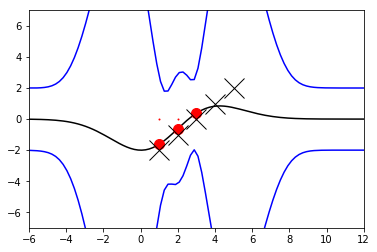

In [71]:
plt.plot(xstar,meanstar,'-k')
plt.plot(xstar,meanstar[:,0] - 2*np.sqrt(np.diag(covstar)),'-b')
plt.plot(xstar,meanstar[:,0] + 2*np.sqrt(np.diag(covstar)),'-b')
plt.plot(inducingX.numpy(),inducingX.numpy()*0,'.r',markersize=2)
plt.plot(inducingX.numpy(),mu.numpy(),'.r',markersize=20)
plt.plot(trainingX.numpy(),trainingY.numpy(),'xk',markersize=20)
plt.ylim([-7,7])
plt.xlim([-6,12])
plt.savefig('weird.png')

In [53]:
mu

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([-2.  , -1.  ,  0.01], dtype=float32)>

In [54]:
cov

array([[ 1.62, -1.83,  0.  ],
       [-1.83,  3.45, -0.  ],
       [ 0.  , -0.  ,  0.  ]], dtype=float32)

In [56]:
import GPy
m = GPy.models.SparseGPRegression(X=trainingX.numpy(),Y=trainingY.numpy(),kernel=GPy.kern.RBF(1,lengthscale=0.1),Z=np.array([1,2,3])[:,None])
m.Z.fix()
m.Gaussian_noise.fix(1e-6)
m.rbf.variance.fix(1.0)
m.rbf.lengthscale.fix(2.0)
m.optimize()
m.inducing_inputs

nothing to optimize


index,sparse_gp.inducing_inputs,constraints,priors
[0 0],1.00,fixed,
[1 0],2.00,fixed,
[2 0],3.00,fixed,


In [58]:
m

sparse_gp.,value,constraints,priors
inducing inputs,"(3, 1)",fixed,
rbf.variance,1.0,+ve fixed,
rbf.lengthscale,2.0,+ve fixed,
Gaussian_noise.variance,1e-06,+ve fixed,


 /home/mike/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


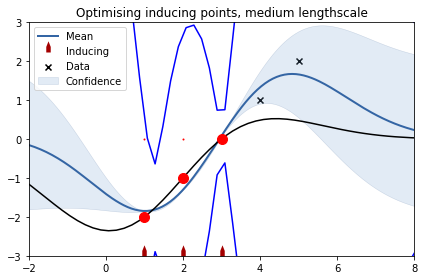

In [57]:
m.plot(plot_limits=[-2,8])
plt.plot(xstar,meanstar,'-k')
plt.plot(xstar,meanstar[:,0] - 2*np.sqrt(np.diag(covstar)),'-b')
plt.plot(xstar,meanstar[:,0] + 2*np.sqrt(np.diag(covstar)),'-b')
plt.ylim([-3,3])
plt.plot(inducingX.numpy(),inducingX.numpy()*0,'.r',markersize=2)
plt.plot(inducingX.numpy(),mu.numpy(),'.r',markersize=20)
plt.title('Optimising inducing points, medium lengthscale')
plt.savefig('demo4.png')

[[ 1.12 -0.16  0.  ]
 [-0.16  0.7  -0.01]
 [ 0.   -0.01  0.  ]]


NameError: name 'pdist' is not defined

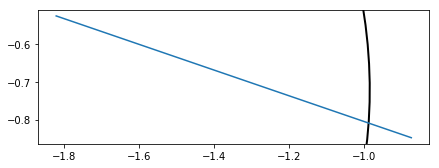

In [32]:
cov = scale.numpy() @ scale.numpy().T
print(cov)
plt.figure(figsize=[7,7])
drawellipse(mu.numpy(),cov,col='k',stds=[1,2])
drawcontour(pdist,xmin=-3,xmax=3,ymin=-3,ymax=3,delta=0.01)
plt.grid()
plt.axis('equal')

In [33]:
import 

SyntaxError: invalid syntax (<ipython-input-33-4cf4f10edf52>, line 1)

In [34]:
inx = np.linspace(-10,10,100)
a = pdist(inx)
#np.sum(a)*(inx[1]-inx[0])
plt.plot(inx,a)
plt.plot(inx,surrogate_posterior.prob(inx))

NameError: name 'pdist' is not defined